In [ ]:
!pip install ipywidgets

In [ ]:
!pip install seaborn

In [ ]:
!pip install transformers

In [ ]:
import sys
!{sys.executable} -m pip install transformers

In [2]:
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from tqdm import tqdm

# Get data

In [3]:
from google.colab import drive
import tensorflow as tf

drive.mount('/content/drive')
%cd drive/MyDrive/twitter_training/

Mounted at /content/drive
/content/drive/MyDrive/twitter_training


In [6]:
df = pd.read_csv('./p_n_n_tilde_lv.csv')
df = df[['id', 'message_lv_tilde', 'label']]
df.head()

,id,message_lv_tilde,label
0,1.340000e+18,@pilsonenjeff @lauferlaw @donwinslows pa reize...,negative
1,1.330000e+18,@tkdylan cilvēkiem ir aģentūra. Lins Vuds ir v...,negative
2,1.330000e+18,"@foenixaew Es nojaušu, ka WWE lika viņam iznāk...",negative
3,1.320000e+18,Maksvels droši vien pačurās mājā pirms mūsu nā...,negative
4,1.320000e+18,@msamson56 Esmu pārsteigts. KĀ cilvēki var atb...,negative


In [7]:
label_dict = {'neutral': 0, 'positive': 1, 'negative': 2}
df['label'] = df.label.replace(label_dict) 
df['label'].value_counts()

0    77028
1    51994
2    45622
Name: label, dtype: int64

In [8]:
newLine ="\\n|\\r"
urls = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
numbers = '\d+((\.|\-)\d+)?'
mentions = '\B\@([\w\-]+)'
hashtag = '#'
whitespaces = '\s+'
leadTrailWhitespace = '^\s+|\s+?$'

df['clean_message'] = df['message_lv_tilde']
df['clean_message'] = df['clean_message'].str.replace(newLine,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(urls,' URL ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(mentions,' MENTION ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(numbers,' NMBR ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(hashtag,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(whitespaces,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(leadTrailWhitespace,'',regex=True)

df.head()

,id,message_lv_tilde,label,clean_message
0,1.340000e+18,@pilsonenjeff @lauferlaw @donwinslows pa reize...,2,MENTION MENTION MENTION pa reizei tādu nav bij...
1,1.330000e+18,@tkdylan cilvēkiem ir aģentūra. Lins Vuds ir v...,2,MENTION cilvēkiem ir aģentūra. Lins Vuds ir va...
2,1.330000e+18,"@foenixaew Es nojaušu, ka WWE lika viņam iznāk...",2,"MENTION Es nojaušu, ka WWE lika viņam iznākt a..."
3,1.320000e+18,Maksvels droši vien pačurās mājā pirms mūsu nā...,2,Maksvels droši vien pačurās mājā pirms mūsu nā...
4,1.320000e+18,@msamson56 Esmu pārsteigts. KĀ cilvēki var atb...,2,MENTION Esmu pārsteigts. KĀ cilvēki var atbals...


# Train, validate split

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

In [10]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['label', 'data_type']).count()

id  message_lv_tilde  clean_message
label data_type                                        
0     train      65474             65474          65474
      val        11554             11554          11554
1     train      44195             44195          44195
      val         7799              7799           7799
2     train      38778             38778          38778
      val         6844              6844           6844

## Balance training data

In [11]:
df[df.data_type=='train']['label'].value_counts()

0    65474
1    44195
2    38778
Name: label, dtype: int64

In [12]:
df_train = [df[df.data_type=='train'].clean_message, df[df.data_type=='train'].label]
df_train = pd.concat(df_train, axis=1, keys=["clean_message", "label"])

df_0 = df_train[df_train['label']==0]
df_1 = df_train[df_train['label']==1]
df_2 = df_train[df_train['label']==2]

df_0_downsampled = df_0.sample(df_2.shape[0], random_state=42)
df_1_downsampled = df_1.sample(df_2.shape[0], random_state=42)

df_train = pd.concat([df_0_downsampled, df_1_downsampled, df_2])

df_train['label'].value_counts()

0    38778
1    38778
2    38778
Name: label, dtype: int64

In [13]:
# Shuffle rows
import sklearn

df_train = sklearn.utils.shuffle(df_train, random_state=0)

df_train.head()

,clean_message,label
173549,Negadījums. divas labās joslas bloķētas TriSta...,0
13774,"labākais, ko ab ir pilnībā ielenkusi tukši dzī...",2
86302,"Piemērojot to visu šajā nākamajā nodaļā, uzspi...",1
77847,"MENTION Es cerēju, ka jūs galu galā izdarīsiet...",1
14670,"MENTION MENTION MENTION MENTION MENTION Jā, mē...",2


# Tokenizer "sentence-transformers/LaBSE"

In [14]:
tokenizer = AutoTokenizer.from_pretrained("./labse_bert_model", do_lower_case=True)

# Add Emoji

In [ ]:
import re

emoji_str = "😀 😃 😄 😁 😆 😅 😂 🤣 😊 😇 🙂 🙃 😉 😌 😍 🥰 😘 😗 😙 😚 😋 😛 😝 😜 🤪 🤨 🧐 🤓 😎 🤩 🥳 😏 😒 😞 😔 😟 😕 🙁 ☹️ 😣 😖 😫 😩 🥺 😢 😭 😤 😠 😡 🤬 🤯 😳 🥵 🥶 😱 😨 😰 😥 😓 🤗 🤔 🤭 🤫 🤥 😶 😐 😑 😬 🙄 😯 😦 😧 😮 😲 🥱 😴 🤤 😪 😵 🤐 🥴 🤢 🤮 🤧 😷 🤒 🤕 😺 😸 😹 😻 😼 😽 🙀 😿 😾 💩 👋 🤚 🖐 ✋ 🖖 👌 🤏 ✌️ 🤞 🤟 🤘 🤙 👈 👉 👆 🖕 👇 ☝️ 👍 👎 ✊ 👊 🤛 🤜 👏 🙌 👐 🤲 🤝 🙏'👋🏻 🤚🏻 🖐🏻 ✋🏻 🖖🏻 👌🏻 🤏🏻 ✌🏻 🤞🏻 🤟🏻 🤘🏻 🤙🏻 👈🏻 👉🏻 👆🏻 🖕🏻 👇🏻 ☝🏻 👍🏻 👎🏻 ✊🏻 👊🏻 🤛🏻 🤜🏻 👏🏻 🙌🏻 👐🏻 🤲🏻 🙏🏻 👋🏼 🤚🏼 🖐🏼 ✋🏼 🖖🏼 👌🏼 🤏🏼 ✌🏼 🤞🏼 🤟🏼 🤘🏼 🤙🏼 👈🏼 👉🏼 👆🏼 🖕🏼 👇🏼 ☝🏼 👍🏼 👎🏼 ✊🏼 👊🏼 🤛🏼 🤜🏼 👏🏼 🙌🏼 👐🏼 🤲🏼 🙏🏼 👋🏽 🤚🏽 🖐🏽 ✋🏽 🖖🏽 👌🏽 🤏🏽 ✌🏽 🤞🏽 🤟🏽 🤘🏽 🤙🏽 👈🏽 👉🏽 👆🏽 🖕🏽 👇🏽 ☝🏽 👍🏽 👎🏽 ✊🏽 👊🏽 🤛🏽 🤜🏽 👏🏽 🙌🏽 👐🏽 🤲🏽 🙏👋🏾 🤚🏾 🖐🏾 ✋🏾 🖖🏾 👌🏾 🤏🏾 ✌🏾 🤞🏾 🤟🏾 🤘🏾 🤙🏾 👈🏾 👉🏾 👆🏾 🖕🏾 👇🏾 ☝🏾 👍🏾 👎🏾 ✊🏾 👊🏾 🤛🏾 🤜🏾 👏🏾 🙌🏾 👐🏾 🤲🏾 🙏 👋🏿 🤚🏿 🖐🏿 ✋🏿 🖖🏿 👌🏿 🤏🏿 ✌🏿 🤞🏿 🤟🏿 🤘🏿 🤙🏿 👈🏿 👉🏿 👆🏿 🖕🏿 👇🏿 ☝🏿 👍🏿 👎🏿 ✊🏿 👊🏿 🤛🏿 🤜🏿 👏🏿 🙌🏿 👐🏿 🤲🏿 🙏🏿 ❤️ 🧡 💛 💚 💙 💜 🖤 🤍 🤎 💔 ❣️ 💕 💞 💓 💗 💖 💘 💝 💟 💑🏻 💑🏼 💑🏽 💑🏾 💑🏿 💏🏻 💏🏼 💏🏽 💏🏾 💏🏿 👨🏻‍❤️‍👨🏻 👨🏻‍❤️‍👨🏼 👨🏻‍❤️‍👨🏽 👨🏻‍❤️‍👨🏾 👨🏻‍❤️‍👨🏿 👨🏼‍❤️‍👨🏻 👨🏼‍❤️‍👨🏼 👨🏼‍❤️‍👨🏽 👨🏼‍❤️‍👨🏾 👨🏼‍❤️‍👨🏿 👨🏽‍❤️‍👨🏻 👨🏽‍❤️‍👨🏼 👨🏽‍❤️‍👨🏽 👨🏽‍❤️‍👨🏾 👨🏽‍❤️‍👨🏿 👨🏾‍❤️‍👨🏻 👨🏾‍❤️‍👨🏼 👨🏾‍❤️‍👨🏽 👨🏾‍❤️‍👨🏾 👨🏾‍❤️‍👨🏿 👨🏿‍❤️‍👨🏻 👨🏿‍❤️‍👨🏼 👨🏿‍❤️‍👨🏽 👨🏿‍❤️‍👨🏾 👨🏿‍❤️‍👨🏿 👩🏻‍❤️‍👨🏻 👩🏻‍❤️‍👨🏼 👩🏻‍❤️‍👨🏽 👩🏻‍❤️‍👨🏾 👩🏻‍❤️‍👨🏿 👩🏻‍❤️‍👩🏻 👩🏻‍❤️‍👩🏼 👩🏻‍❤️‍👩🏽 👩🏻‍❤️‍👩🏾 👩🏻‍❤️‍👩🏿 👩🏼‍❤️‍👨🏻 👩🏼‍❤️‍👨🏼 👩🏼‍❤️‍👨🏽 👩🏼‍❤️‍👨🏾 👩🏼‍❤️‍👨🏿 👩🏼‍❤️‍👩🏻 👩🏼‍❤️‍👩🏼 👩🏼‍❤️‍👩🏽 👩🏼‍❤️‍👩🏾 👩🏼‍❤️‍👩🏿 👩🏽‍❤️‍👨🏻 👩🏽‍❤️‍👨🏼 👩🏽‍❤️‍👨🏽 👩🏽‍❤️‍👨🏾 👩🏽‍❤️‍👨🏿 👩🏽‍❤️‍👩🏻 👩🏽‍❤️‍👩🏼 👩🏽‍❤️‍👩🏽 👩🏽‍❤️‍👩🏾 👩🏽‍❤️‍👩🏿 👩🏾‍❤️‍👨🏻 👩🏾‍❤️‍👨🏼 👩🏾‍❤️‍👨🏽 👩🏾‍❤️‍👨🏾 👩🏾‍❤️‍👨🏿 👩🏾‍❤️‍👩🏻 👩🏾‍❤️‍👩🏼 👩🏾‍❤️‍👩🏽 👩🏾‍❤️‍👩🏾 👩🏾‍❤️‍👩🏿 👩🏿‍❤️‍👨🏻 👩🏿‍❤️‍👨🏼 👩🏿‍❤️‍👨🏽 👩🏿‍❤️‍👨🏾 👩🏿‍❤️‍👨🏿 👩🏿‍❤️‍👩🏻 👩🏿‍❤️‍👩🏼 👩🏿‍❤️‍👩🏽 👩🏿‍❤️‍👩🏾 👩🏿‍❤️‍👩🏿 🧑🏻‍❤️‍🧑🏼 🧑🏻‍❤️‍🧑🏽 🧑🏻‍❤️‍🧑🏾 🧑🏻‍❤️‍🧑🏿 🧑🏼‍❤️‍🧑🏻 🧑🏼‍❤️‍🧑🏽 🧑🏼‍❤️‍🧑🏾 🧑🏼‍❤️‍🧑🏿 🧑🏽‍❤️‍🧑🏻 🧑🏽‍❤️‍🧑🏼 🧑🏽‍❤️‍🧑🏾 🧑🏽‍❤️‍🧑🏿 🧑🏾‍❤️‍🧑🏻 🧑🏾‍❤️‍🧑🏼 🧑🏾‍❤️‍🧑🏽 🧑🏾‍❤️‍🧑🏿 🧑🏿‍❤️‍🧑🏻 🧑🏿‍❤️‍🧑🏼 🧑🏿‍❤️‍🧑🏽 🧑🏿‍❤️‍🧑🏾 👨🏻‍❤️‍💋‍👨🏻 👨🏻‍❤️‍💋‍👨🏼 👨🏻‍❤️‍💋‍👨🏽 👨🏻‍❤️‍💋‍👨🏾 👨🏻‍❤️‍💋‍👨🏿 👨🏼‍❤️‍💋‍👨🏻 👨🏼‍❤️‍💋‍👨🏼 👨🏼‍❤️‍💋‍👨🏽 👨🏼‍❤️‍💋‍👨🏾 👨🏼‍❤️‍💋‍👨🏿 👨🏽‍❤️‍💋‍👨🏻 👨🏽‍❤️‍💋‍👨🏼 👨🏽‍❤️‍💋‍👨🏽 👨🏽‍❤️‍💋‍👨🏾 👨🏽‍❤️‍💋‍👨🏿 👨🏾‍❤️‍💋‍👨🏻 👨🏾‍❤️‍💋‍👨🏼 👨🏾‍❤️‍💋‍👨🏽 👨🏾‍❤️‍💋‍👨🏾 👨🏾‍❤️‍💋‍👨🏿 👨🏿‍❤️‍💋‍👨🏻 👨🏿‍❤️‍💋‍👨🏼 👨🏿‍❤️‍💋‍👨🏽 👨🏿‍❤️‍💋‍👨🏾 👨🏿‍❤️‍💋‍👨🏿 👩🏻‍❤️‍💋‍👨🏻 👩🏻‍❤️‍💋‍👨🏼 👩🏻‍❤️‍💋‍👨🏽 👩🏻‍❤️‍💋‍👨🏾 👩🏻‍❤️‍💋‍👨🏿 👩🏻‍❤️‍💋‍👩🏻 👩🏻‍❤️‍💋‍👩🏼 👩🏻‍❤️‍💋‍👩🏽 👩🏻‍❤️‍💋‍👩🏾 👩🏻‍❤️‍💋‍👩🏿 👩🏼‍❤️‍💋‍👨🏻 👩🏼‍❤️‍💋‍👨🏼 👩🏼‍❤️‍💋‍👨🏽 👩🏼‍❤️‍💋‍👨🏾 👩🏼‍❤️‍💋‍👨🏿 👩🏼‍❤️‍💋‍👩🏻 👩🏼‍❤️‍💋‍👩🏼 👩🏼‍❤️‍💋‍👩🏽 👩🏼‍❤️‍💋‍👩🏾 👩🏼‍❤️‍💋‍👩🏿 👩🏽‍❤️‍💋‍👨🏻 👩🏽‍❤️‍💋‍👨🏼 👩🏽‍❤️‍💋‍👨🏽 👩🏽‍❤️‍💋‍👨🏾 👩🏽‍❤️‍💋‍👨🏿 👩🏽‍❤️‍💋‍👩🏻 👩🏽‍❤️‍💋‍👩🏼 👩🏽‍❤️‍💋‍👩🏽 👩🏽‍❤️‍💋‍👩🏾 👩🏽‍❤️‍💋‍👩🏿 👩🏾‍❤️‍💋‍👨🏻 👩🏾‍❤️‍💋‍👨🏼 👩🏾‍❤️‍💋‍👨🏽 👩🏾‍❤️‍💋‍👨🏾 👩🏾‍❤️‍💋‍👨🏿 👩🏾‍❤️‍💋‍👩🏻 👩🏾‍❤️‍💋‍👩🏼 👩🏾‍❤️‍💋‍👩🏽 👩🏾‍❤️‍💋‍👩🏾 👩🏾‍❤️‍💋‍👩🏿 👩🏿‍❤️‍💋‍👨🏻 👩🏿‍❤️‍💋‍👨🏼 👩🏿‍❤️‍💋‍👨🏽 👩🏿‍❤️‍💋‍👨🏾 👩🏿‍❤️‍💋‍👨🏿 👩🏿‍❤️‍💋‍👩🏻 👩🏿‍❤️‍💋‍👩🏼 👩🏿‍❤️‍💋‍👩🏽 👩🏿‍❤️‍💋‍👩🏾 👩🏿‍❤️‍💋‍👩🏿 🧑🏻‍❤️‍💋‍🧑🏼 🧑🏻‍❤️‍💋‍🧑🏽 🧑🏻‍❤️‍💋‍🧑🏾 🧑🏻‍❤️‍💋‍🧑🏿 🧑🏼‍❤️‍💋‍🧑🏻 🧑🏼‍❤️‍💋‍🧑🏽 🧑🏼‍❤️‍💋‍🧑🏾 🧑🏼‍❤️‍💋‍🧑🏿 🧑🏽‍❤️‍💋‍🧑🏻 🧑🏽‍❤️‍💋‍🧑🏼 🧑🏽‍❤️‍💋‍🧑🏾 🧑🏽‍❤️‍💋‍🧑🏿 🧑🏾‍❤️‍💋‍🧑🏻 🧑🏾‍❤️‍💋‍🧑🏼 🧑🏾‍❤️‍💋‍🧑🏽 🧑🏾‍❤️‍💋‍🧑🏿 🧑🏿‍❤️‍💋‍🧑🏻 🧑🏿‍❤️‍💋‍🧑🏼 🧑🏿‍❤️‍💋‍🧑🏽 🧑🏿‍❤️‍💋‍🧑🏾 👭 🧑‍🤝‍🧑 👬 👫 👩‍❤️‍👩 💑 👨‍❤️‍👨 👩‍❤️‍👨 👩‍❤️‍💋‍👩 💏 👨‍❤️‍💋‍👨 👩‍❤️‍💋‍👨 👪 👨‍👩‍👦 👨‍👩‍👧 👨‍👩‍👧‍👦 👨‍👩‍👦‍👦 👨‍👩‍👧‍👧 👨‍👨‍👦 👨‍👨‍👧 👨‍👨‍👧‍👦 👨‍👨‍👦‍👦 👨‍👨‍👧‍👧 👩‍👩‍👦 👩‍👩‍👧 👩‍👩‍👧‍👦 👩‍👩‍👦‍👦 👩‍👩‍👧‍👧 👨‍👦 👨‍👦‍👦 👨‍👧 👨‍👧‍👦 👨‍👧‍👧 👩‍👦 👩‍👦‍👦 👩‍👧 👩‍👧‍👦 👩‍ 👧‍👧 💋"
emoji_list = emoji_str.split(' ')
emoji_regex = '|'.join(emoji_list)

In [ ]:
all_emoji = []
for message in df.clean_message:
    foundEmoji = re.findall(emoji_regex, message)
    for emoji in foundEmoji:
        all_emoji.append(emoji)

print(len(all_emoji))

44234


In [ ]:
import collections

counter=collections.Counter(all_emoji)
print(counter.most_common(100))

most_common_values= [word for word, word_count in counter.most_common(100)]

[('😂', 6968), ('😭', 4638), ('🤣', 2528), ('🙏', 1916), ('🥺', 1084), ('😩', 1058), ('🤔', 903), ('🥰', 899), ('🥴', 869), ('👏', 840), ('😍', 838), ('🙄', 775), ('🙌', 672), ('💙', 639), ('😅', 568), ('💜', 543), ('💕', 540), ('😊', 509), ('👍', 477), ('😘', 474), ('😔', 464), ('💔', 454), ('😒', 446), ('🙃', 425), ('😎', 398), ('😉', 388), ('😁', 365), ('😢', 359), ('😌', 355), ('🖤', 347), ('😆', 310), ('🤗', 307), ('😳', 298), ('🥳', 292), ('✊', 289), ('😤', 289), ('💛', 288), ('😬', 282), ('🤬', 281), ('👇', 271), ('😡', 266), ('👌', 265), ('🤩', 265), ('💖', 259), ('😫', 255), ('💋', 251), ('🤍', 250), ('💚', 231), ('💗', 217), ('🙂', 212), ('😞', 206), ('😷', 202), ('🤯', 202), ('😀', 193), ('😴', 188), ('😋', 185), ('😏', 179), ('🤞', 174), ('😜', 174), ('👉', 168), ('🤘', 154), ('😪', 154), ('🤤', 154), ('😑', 152), ('🤪', 152), ('😐', 141), ('😱', 139), ('😄', 132), ('👊', 128), ('🤢', 122), ('🤨', 121), ('🧐', 120), ('🥶', 116), ('😕', 115), ('💩', 113), ('😇', 112), ('🤮', 109), ('🥵', 106), ('🤧', 104), ('👋', 103), ('👎', 99), ('😖', 97), ('🤓', 96), 

In [15]:
c=[('😂', 6968), ('😭', 4638), ('🤣', 2528), ('🙏', 1916), ('🥺', 1084), ('😩', 1058), ('🤔', 903), ('🥰', 899), ('🥴', 869), ('👏', 840), ('😍', 838), ('🙄', 775), ('🙌', 672), ('💙', 639), ('😅', 568), ('💜', 543), ('💕', 540), ('😊', 509), ('👍', 477), ('😘', 474), ('😔', 464), ('💔', 454), ('😒', 446), ('🙃', 425), ('😎', 398), ('😉', 388), ('😁', 365), ('😢', 359), ('😌', 355), ('🖤', 347), ('😆', 310), ('🤗', 307), ('😳', 298), ('🥳', 292), ('✊', 289), ('😤', 289), ('💛', 288), ('😬', 282), ('🤬', 281), ('👇', 271), ('😡', 266), ('👌', 265), ('🤩', 265), ('💖', 259), ('😫', 255), ('💋', 251), ('🤍', 250), ('💚', 231), ('💗', 217), ('🙂', 212), ('😞', 206), ('😷', 202), ('🤯', 202), ('😀', 193), ('😴', 188), ('😋', 185), ('😏', 179), ('🤞', 174), ('😜', 174), ('👉', 168), ('🤘', 154), ('😪', 154), ('🤤', 154), ('😑', 152), ('🤪', 152), ('😐', 141), ('😱', 139), ('😄', 132), ('👊', 128), ('🤢', 122), ('🤨', 121), ('🧐', 120), ('🥶', 116), ('😕', 115), ('💩', 113), ('😇', 112), ('🤮', 109), ('🥵', 106), ('🤧', 104), ('👋', 103), ('👎', 99), ('😖', 97), ('🤓', 96), ('😃', 96), ('🥱', 94), ('💞', 93), ('😓', 91), ('🤝', 90), ('🧡', 89), ('😹', 86), ('🖕', 85), ('😝', 84), ('😣', 75), ('🤫', 71), ('😰', 71), ('😥', 70), ('🤭', 70), ('💓', 59), ('😠', 58), ('😮', 55)]
most_common_values= [word for word, word_count in c]

In [16]:
tokenizer.add_tokens(most_common_values, special_tokens=True)

10

### Find max length for tokenizer

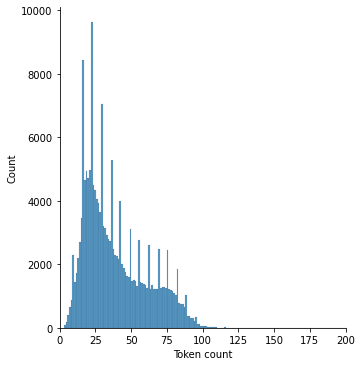

In [ ]:
token_lens = []
for txt in list(df.clean_message.values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
sns.displot(token_lens)
plt.xlim([0, 200])
plt.xlabel('Token count')
plt.show()

In [17]:
max_length = 120

### Encode messages

In [18]:
encoded_data_train = tokenizer.batch_encode_plus(
    df_train["clean_message"].values.tolist(), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].clean_message.values.tolist(), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_train.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [19]:
len(dataset_train), len(dataset_val)

(116334, 26197)

# Model "LaBSE" pytorch

In [20]:
model = AutoModelForSequenceClassification.from_pretrained("./labse_bert_model", num_labels = 3)

Some weights of the model checkpoint at ./labse_bert_model were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initial

In [21]:
model.resize_token_embeddings(len(tokenizer))

Embedding(501163, 768)

In [22]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

In [23]:
from transformers import get_linear_schedule_with_warmup

# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)

In [24]:
epochs = 1

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

In [25]:
# Function to measure weighted F1

from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [26]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model.to(device)
print(device)

cuda


In [27]:
# Function to evaluate model. Returns average validation loss, predictions, true values

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    progress_bar = tqdm(dataloader_val, desc='Validating:', leave=False, disable=False)
    for batch in progress_bar:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

# Train

In [28]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'labseEmoji-pnn/finetuned_LaBSE_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    
    preds_flat = np.argmax(predictions, axis=1).flatten()
    
    print('Classification report:')
    print(classification_report(true_vals, preds_flat))
    print('Confusion matrix:')
    print(pd.DataFrame(confusion_matrix(true_vals, preds_flat),
            index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
            columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']]))

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/3636 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.1023197038011059


Validating::   0%|          | 0/819 [00:00<?, ?it/s]

Validation loss: 1.1070670861027616
F1 Score (Weighted): 0.3311232491113713
Classification report:
              precision    recall  f1-score   support

           0       0.53      0.25      0.33     11554
           1       0.28      0.45      0.35      7799
           2       0.28      0.34      0.31      6844

    accuracy                           0.33     26197
   macro avg       0.36      0.35      0.33     26197
weighted avg       0.39      0.33      0.33     26197

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral       2833     5441     3280
       positive      1552     3512     2735
       negative      1003     3503     2338


# Evaluate

In [ ]:
model.load_state_dict(torch.load('./modelsEmoji-pnn/finetuned_LaBSE_epoch_1.model', map_location=torch.device('cpu')))

OSError: [Errno 22] Invalid argument

In [ ]:
_, predictions, true_vals = evaluate(dataloader_validation)
preds_flat = np.argmax(predictions, axis=1).flatten()

In [ ]:
f1_score_func(predictions, true_vals)

NameError: name 'predictions' is not defined

In [ ]:
print(classification_report(true_vals, preds_flat))

              precision    recall  f1-score   support

           0       0.47      0.22      0.30     11554
           1       0.29      0.57      0.39      7799
           2       0.27      0.22      0.24      6844

    accuracy                           0.33     26197
   macro avg       0.35      0.34      0.31     26197
weighted avg       0.37      0.33      0.31     26197



In [ ]:
pd.DataFrame(confusion_matrix(true_vals, preds_flat),
        index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
        columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']])

predicted                  
                  neutral positive negative
actual neutral       2597     6937     2020
       positive      1345     4452     2002
       negative      1558     3791     1495